# Import

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gym

# Config

In [2]:
INPUT_DIM = 4
ACTION_DIM = 2

NUM_EPISODE = 150
RENDER = False # Visualize but slow
REWARD_SUM_QUEUE_SIZE = 100

# Network

In [3]:
class Network(object): # Policy and Value Network
    def __init__(self, device):
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with tf.device(device):
                self.create_placeholder()
                self.create_network()
                self.create_train_op()
                self.sess = tf.Session(
                    graph=self.graph,
                    config=tf.ConfigProto(
                        allow_soft_placement=True,
                        log_device_placement=False,
                        gpu_options=tf.GPUOptions(allow_growth=True)))
                self.sess.run(tf.global_variables_initializer()) 

    def create_placeholder(self):
        self.state_t = tf.placeholder(tf.float32, [None, INPUT_DIM], name='state_t') # states
        self.y_r = tf.placeholder(tf.float32, [None], name='Yr') # accumulated reawrd
        self.action_t = tf.placeholder(tf.float32, [None, ACTION_DIM], name='action_t')

    def create_network(self):
        fc_p_1 = tf.layers.dense(self.state_t, 10, activation=tf.nn.relu, name='fc_p_1')
        fc_p_2 = tf.layers.dense(fc_p_1, 10, activation=tf.nn.relu, name='fc_p_2')
        self.logits_p = tf.layers.dense(fc_p_2, ACTION_DIM, activation=None, name='logits_p')
        self.softmax_p = tf.nn.softmax(self.logits_p)

        fc_v_1 = tf.layers.dense(self.state_t, 10, activation=tf.nn.relu, name='fc_v_1')
        fc_v_2 = tf.layers.dense(fc_v_1, 10, activation=tf.nn.relu, name='fc_v_2')
        self.logits_v = tf.layers.dense(fc_v_2, 1, activation=None, name='logits_v')

    def create_train_op(self):
        self.log_softmax_p = tf.nn.log_softmax(self.logits_p)
        self.log_selected_action_prob = tf.reduce_sum(self.log_softmax_p * self.action_t, axis=1)
        self.cost_p = -tf.reduce_sum(self.log_selected_action_prob * (self.y_r - tf.stop_gradient(self.logits_v)), axis=0)
        self.cost_v = 0.5 * tf.reduce_sum(tf.square(self.y_r - self.logits_v), axis=0)

        self.cost_all = self.cost_p + self.cost_v 

        self.opt = tf.train.AdamOptimizer(0.01)
        self.train_op = self.opt.minimize(self.cost_all)

    def predict_p_and_v_single(self, state_t):
        prediction_p = self.sess.run(self.softmax_p, feed_dict={self.state_t: state_t[np.newaxis, :]})
        prediction_v = self.sess.run(self.logits_v, feed_dict={self.state_t: state_t[np.newaxis, :]})
        return prediction_p[0], prediction_v[0]

    def train(self, state_t, y_r, action_t):
        self.sess.run(self.train_op, feed_dict={self.state_t: state_t, self.y_r: y_r, self.action_t: action_t})

# Agent

In [4]:
class Agent(object):
    def __init__(self, network):
        self.network = network 
        self.actions = np.arange(ACTION_DIM)
        self.discount_factor = 0.99

    def train_network(self, x_, r_, a_):
        self.network.train(x_, r_, a_)

    def predict(self, x):
        return self.network.predict_p_and_v_single(x)

    def select_action(self, prediction):
        action = np.random.choice(self.actions, p=prediction)
        return action

    def convert_data(self, experiences):
        x_ = np.array([exp.state for exp in experiences])
        a_ = np.eye(ACTION_DIM)[np.array([exp.action for exp in experiences])].astype(np.float32)
        r_ = np.array([exp.reward for exp in experiences])
        return x_, r_, a_

    @staticmethod
    def accumulate_rewards(experiences, discount_factor, terminal_reward):
        reward_sum = terminal_reward
        for t in reversed(range(0, len(experiences)-1)):
            reward_sum = discount_factor * reward_sum + experiences[t].reward
            experiences[t].reward = reward_sum
        return experiences[:-1]

# Train

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0, avg_score: 15.00
episode: 1, avg_score: 12.50
episode: 2, avg_score: 12.33
episode: 3, avg_score: 12.25
episode: 4, avg_score: 17.40
episode: 5, avg_score: 17.17
episode: 6, avg_score: 17.43
episode: 7, avg_score: 16.88
episode: 8, avg_score: 17.00
episode: 9, avg_score: 16.40
episode: 10, avg_score: 20.00
episode: 11, avg_score: 19.83
episode: 12, avg_score: 20.54
episode: 13, avg_score: 19.64
episode: 14, avg_score: 20.07
episode: 15, avg_score: 22.88
episode: 16, avg_score: 23.18
episode: 17, avg_score: 23.28
episode: 18, avg_score: 27.53
episode: 19, avg_score: 27.05
episode: 20, avg_score: 27.19
episode: 21, avg_score: 27.05
episode: 22, avg_score: 26.61
episode: 23, avg_score: 26.54
episode: 24, avg_score: 25.96
episode: 25, avg_score: 25.38
episode: 26, avg_score: 25.07
episode: 27, avg_score: 24.93
episode: 28, avg_score: 24.79
episode: 29, avg_score: 25.17
episode: 30

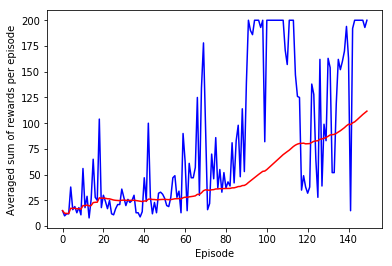

In [5]:
class Experience(object):
    def __init__(self, state, action, prediction, reward, done):
        self.state = state
        self.action = action
        self.prediction = prediction
        self.reward = reward
        self.done = done

env = gym.make('CartPole-v0')
network = Network("cpu:0")
agent = Agent(network)

reward_sum_queue = []
reward_sum_history = []
reward_sum_avg_history = []
for n_episode in range(NUM_EPISODE):
    state = env.reset()

    done = False
    reward_sum = 0.0

    experiences = []
    while not done:
        if RENDER:
            env.render()

        prediction, value = agent.predict(state)
        action = agent.select_action(prediction)

        prev_state = state 
        state, reward, done, _ = env.step(action)
        reward_sum += reward

        exp = Experience(prev_state, action, prediction, reward, done)
        experiences.append(exp)

        if done:
            if len(reward_sum_queue) > REWARD_SUM_QUEUE_SIZE:
                reward_sum_queue.append(reward_sum)
                reward_sum_queue.pop(0)
            else:
                reward_sum_queue.append(reward_sum)
            reward_sum_history.append(reward_sum)
            reward_sum_avg_history.append(np.mean(reward_sum_queue))

            terminal_reward = 0
            updated_exps = Agent.accumulate_rewards(
                experiences,
                agent.discount_factor,
                terminal_reward)
            x_, r_, a_ = agent.convert_data(updated_exps)

            agent.train_network(x_, r_, a_)

            print("episode: %d, avg_score: %.2f"
            % (n_episode, np.mean(reward_sum_queue)))

plt.plot(reward_sum_history, 'b')
plt.plot(reward_sum_avg_history, 'r')
plt.xlabel('Episode')
plt.ylabel('Averaged sum of rewards per episode')
plt.show()